# Feature Extraction: HOG

## Setup

In [1]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from skimage import data, exposure

In [2]:
#paths
root = '.'
data_folder = f'{root}/data'

## Load Data

In [3]:
def load_data(path_to_data):
    """
    load 2D images and their labels

    returns: 
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []
    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
            .decode("pil").to_tuple("jpg", "json"))
    #iterate dataset
    data_iter = iter(data)
    #append dataset to lists
    for row in data_iter:
        image = np.array(row[0])
        label = row[1]['label']
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()
    return images, labels      

In [4]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

7


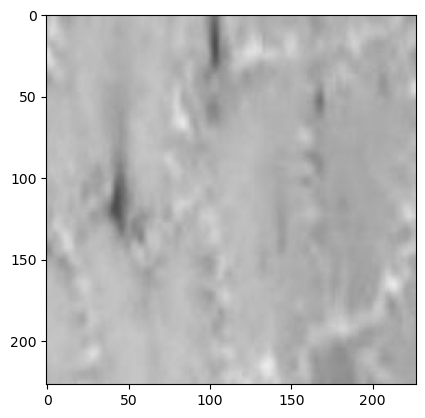

In [5]:
print(train_labels[0])
plt.imshow(train_images[0])

In [6]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8960, 227, 227, 3)
Shape of labels: (8960,)


## Quick EDA

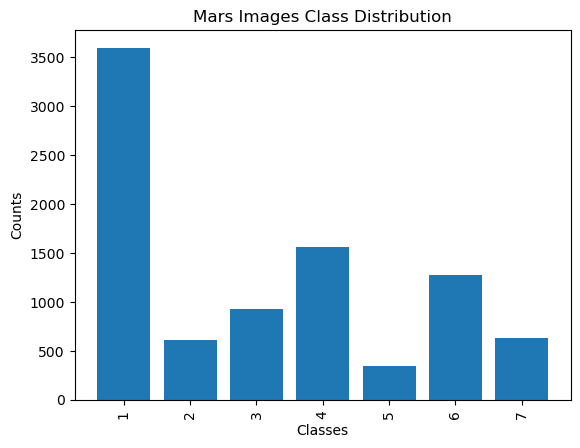

In [7]:
unique, counts = np.unique(train_labels, return_counts=True)
class_dict = dict(zip(unique, counts))
#plot
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center')
plt.xticks(range(len(class_dict)), list(class_dict.keys()), rotation = 'vertical')
plt.title('Mars Images Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

{1: 7, 2: 448, 3: 602, 4: 2478, 5: 35, 6: 1407, 7: 0}


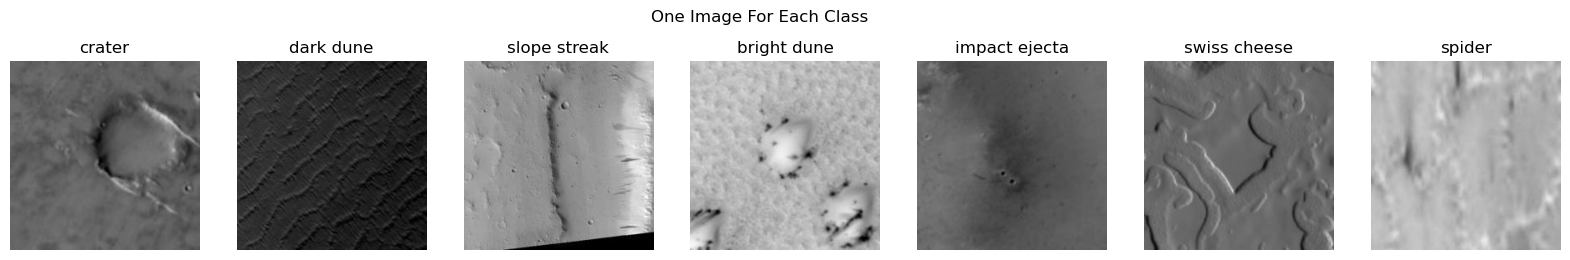

In [8]:
#show example of 1 of each class
label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
result = {}
unique_values = np.unique(train_labels)
for value in unique_values:
    indices = np.where(train_labels==value)[0][:1]
    result[value] = np.int_(indices)[0]
print(result)
#plotting first image for each class
fig, axs = plt.subplots(nrows=1, ncols=len(result), figsize=(20,3))
i = 0
for key, value in result.items():
    image = train_images[value]
    label = label_names[key-1]
    #label_name = label_names[label]
    axs[i].imshow(image)
    axs[i].set_title(label)
    axs[i].axis('off')
    i += 1
fig.suptitle('One Image For Each Class')
plt.show()

## Feature Extraction: HOG

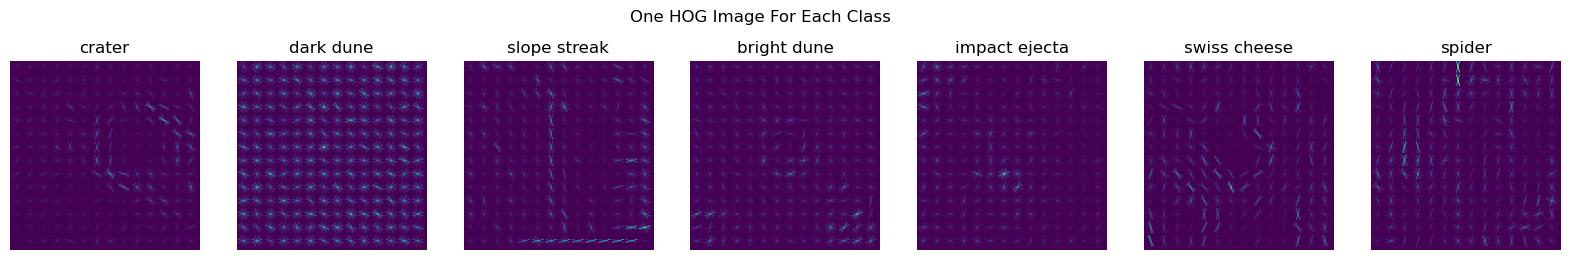

In [10]:
#start with 1 example for each class for visualization
fig, axs = plt.subplots(nrows=1, ncols=len(result), figsize=(20,3))
i = 0
for key, value in result.items():
    image = train_images[value]
    label = label_names[key-1]
    fd, hog_image = hog(image, orientations = 8, pixels_per_cell=(16,16),
                        cells_per_block= (1,1), visualize = True, channel_axis=-1)
    axs[i].imshow(hog_image)
    axs[i].set_title(label)
    axs[i].axis('off')
    i += 1
fig.suptitle('One HOG Image For Each Class')
plt.show()
    

In [11]:
#apply to all
def extract_hog(img_dataset):
    """ 
    Apply HOG feature extraction to all training images 
    args: img_dataset (training / testing dataset)

    returns: train_images_hog (dataset of hog features)
    """
    img_dataset_hog = []
    for img in img_dataset:
        fd, hog_image = hog(image, orientations = 8, pixels_per_cell=(16,16),
                        cells_per_block= (1,1), visualize = True, channel_axis=-1)
        
        train_images_hog.append(hog_image)

    img_dataset_hog = np.array(img_dataset_hog)
    return img_dataset_hog

In [12]:
train_images_hog = extract_hog(train_images)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


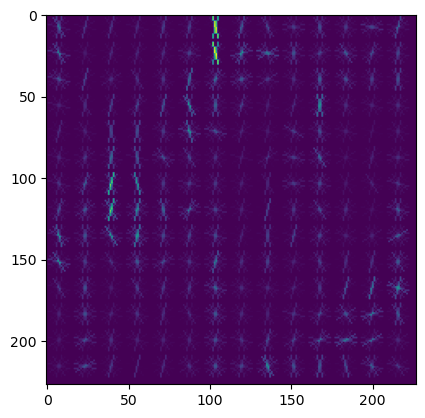

In [13]:
plt.imshow(train_images_hog[0])